In [1]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet

In [1]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data
import numpy as np
import pandas as pd
from KC_algorithm.model import score_KCs
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs


def run():
    [edf_file] = fetch_data(subjects=[0], recording=[1])

    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}


    #### Load edf file##
    raw = mne.io.read_raw_edf(edf_file[0], preload=True)
    raw, _ = mne.set_eeg_reference(raw, [], verbose='warning')
    raw.resample(128)
    raw = raw.filter(0.3, None)
    Fs = raw.info['sfreq']

    ### Load and transform hypnogram ####
    annot = mne.read_annotations(edf_file[1])

    raw.set_annotations(annot, emit_warning=False)
    raw.set_channel_types(mapping)

    annotation_desc_2_event_id = {'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4,
                                  'Sleep stage R': 5}

    events_train, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    hypno = pd.DataFrame([])
    hypno['onset'] = events_train[:,0]/Fs
    hypno['dur'] = np.ones_like(events_train[:,0])*30
    hypno['label'] = events_train[:,2]


    ## Parameters for K-complex scoring##

    # The algorithm was trained on C3, as you will see the algorithm
    # does not perform well on Fpz-Cz
    wanted_channel = 'EEG Fpz-Cz' #
    C3 = np.asarray(
        [raw[count, :][0] for count, k in enumerate(raw.info['ch_names']) if
         k == wanted_channel]).ravel()*-1

    Fs = raw.info['sfreq']



    peaks, stage_peaks, d, probas = score_KCs(C3, Fs, hypno,sleep_stages=[2,3])


    #######################################################################
    probability_threshold = 0.5 # include only waveform scored with a probability of at least 50%

    labels_detected = np.where(probas>probability_threshold,1,0)
    onsets_detected = peaks[probas>probability_threshold]
    probas_detected = probas[probas>probability_threshold]

    print('{} K-complexes were detected'.format(np.sum(labels_detected)))
    #


    ########################################################################
    ####                        VIZUALISATION                           ####

    ##----- Average K-complexes for different probability threshold ------##
    KC_from_probas(C3*-1,onsets_detected,probas_detected,Fs)
    plot_all_Kcs(C3 * -1, peaks, probas, Fs)
    
    ##------------------------Plotting with mne --------------------------##

    tmin = -2
    tmax= 2

    events_mne = np.vstack([onsets_detected, np.zeros_like(onsets_detected), np.ones_like(onsets_detected)]).T

    # Use the correct channel names in picks
    ep = mne.Epochs(raw, events_mne, picks='eeg', baseline=None, tmin=tmin, tmax=tmax)

    
    # Plot each individuals K-complexes
    ep.plot(block=True)

    # Plot a similar Figure 4 in our manuscript
    ep.plot_image(group_by=None, picks='eeg', vmin=-50, vmax=50)

Updated sk-learn import path


Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/ec2-user/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 1409 samples (11.008 s)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
370 K-complexes were detected


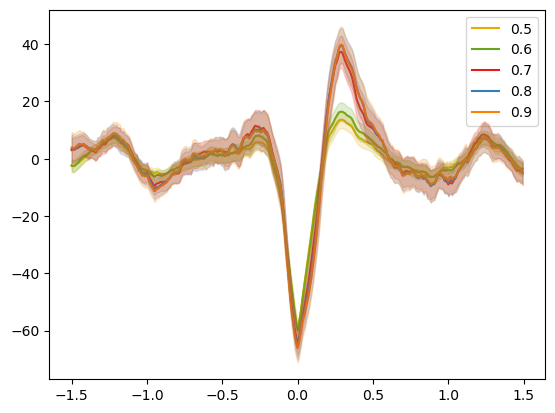

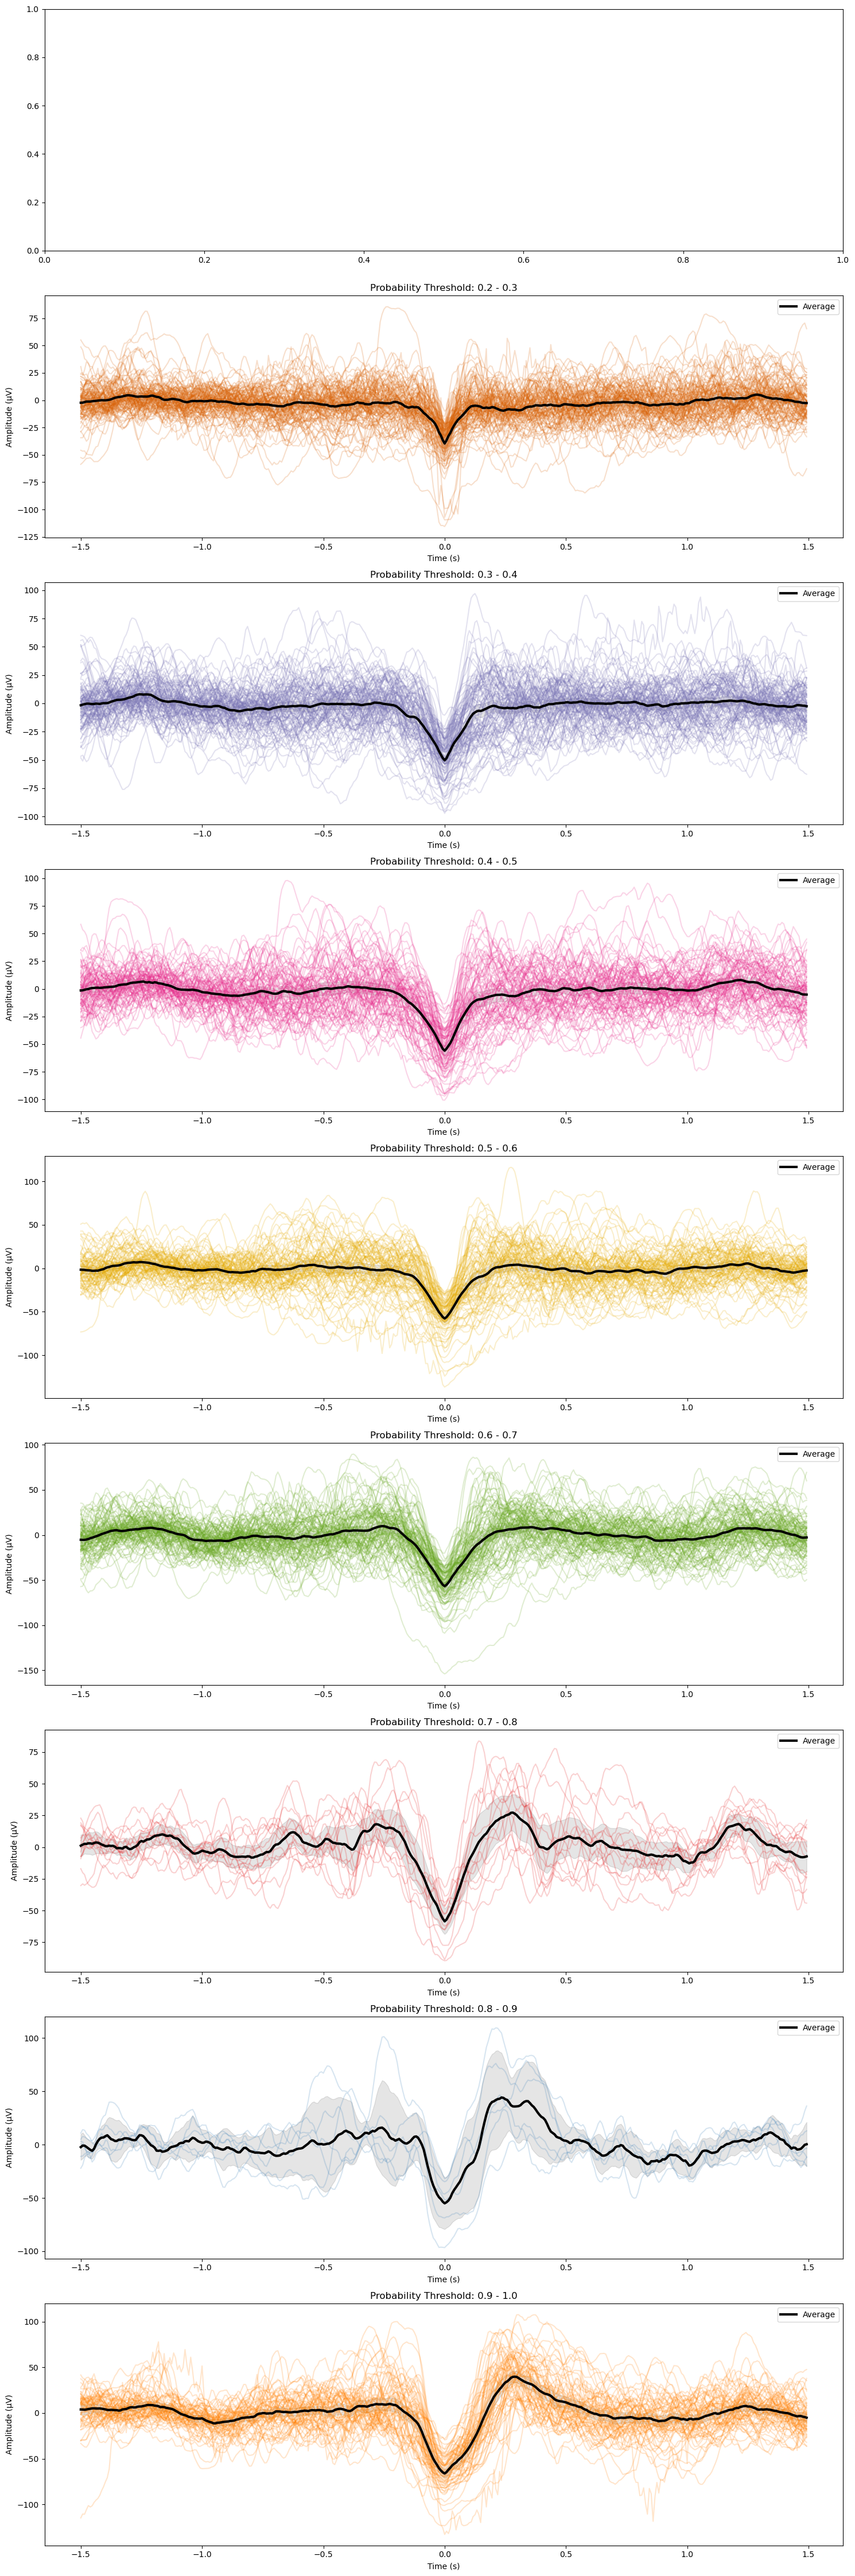

0 bad epochs dropped
Using matplotlib as 2D backend.
Using data from preloaded Raw for 20 events and 513 original time points ...


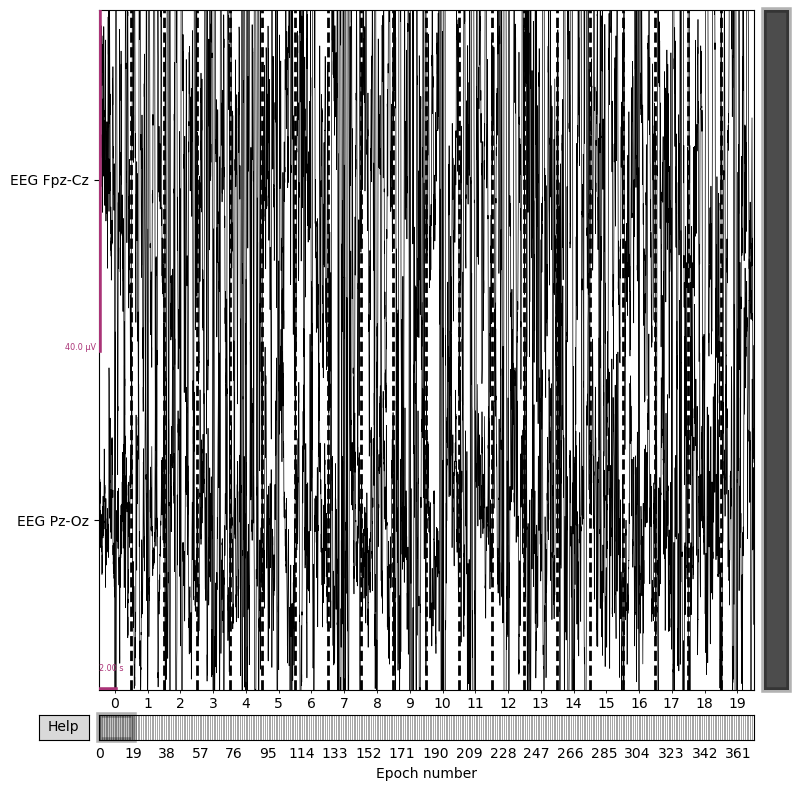

Using data from preloaded Raw for 370 events and 513 original time points ...
Not setting metadata
370 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


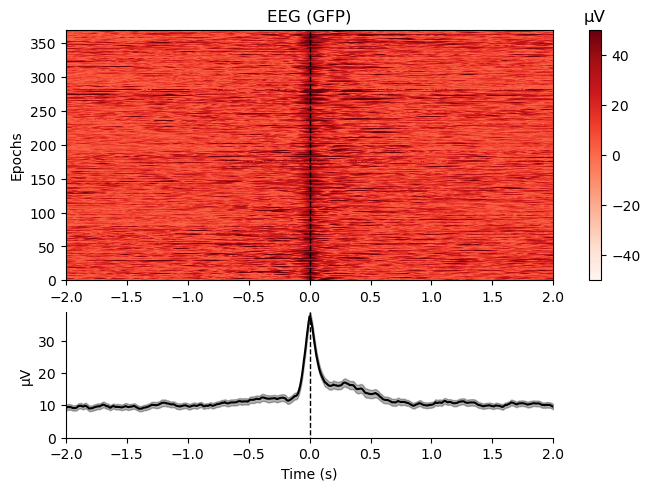

In [2]:
run()